In [1]:
from src.utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

import torch

import scipy
import librosa

from sklearn.model_selection import train_test_split

In [2]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [3]:
meta_data_aphasia = pd.read_excel(os.path.join(DATA_DIR, "Demo RAT discourse production.xlsx"), sheet_name='пациенты')
meta_data_norm = pd.read_excel(os.path.join(DATA_DIR, "Demo RAT discourse production.xlsx"), sheet_name='норма')

meta_data_norm.drop(meta_data_norm.index[-1], axis=0, inplace=True)
meta_data_aphasia["Subj_ID"] = meta_data_aphasia["Subj_ID"].astype(str)
meta_data_norm.rename(columns={"№": "Subj_ID"}, inplace=True)
meta_data_norm["Subj_ID"] = meta_data_norm["Subj_ID"].astype(str)

In [4]:
meta_data_aphasia.rename(columns={'Stroked hemisphere (L/R/LR)': 'Stroked hemisphere',
                          'Aphasia/Norm (A/N), A includes all patients, even with just dysarthria': 'Aphasia/Norm', 
                          'Aphasia_Severity \n0 - no aphasia\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Aphasia_Severity',
                          'Aphasia_Types\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Aphasia_Types',
                          'Dominant_Aphasia\n1 - efferent motor\n2 - afferent motor\n3 - complex motor\n4 - dynamic\n5 - acoustic-mnestic\n6 - sensory\n7 - semantic\n8 - other': 'Dominant_Aphasia',
                          'Dysarthria (1/0)': 'Dysarthria',
                          'Dysarthria_Severity \n0 - no dysarthria\n1 - very mild\n2 - mild\n3 - mild-moderate\n4 - moderate\n5 - moderate-severe\n6 - severe\n7 - very severe': 'Dysarthria_Severity',
                          }, inplace=True)

In [5]:
meta_data_aphasia.Aphasia_Severity.value_counts()

Aphasia_Severity
4.0    130
2.0     57
5.0     53
3.0     40
0.0     39
6.0     19
1.0      4
7.0      1
Name: count, dtype: int64

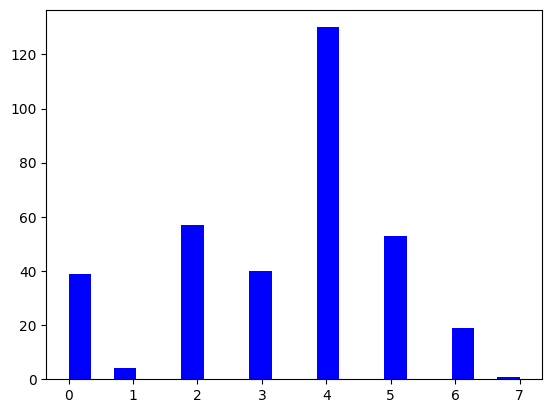

In [6]:
plt.hist(meta_data_aphasia["Aphasia_Severity"].to_list(), bins=20, color="blue", label="Афазия");

In [7]:
severity2class = {
    0: 4,
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
}

In [8]:
meta_data_aphasia["Aphasia_Severity"] = meta_data_aphasia["Aphasia_Severity"].map(severity2class)

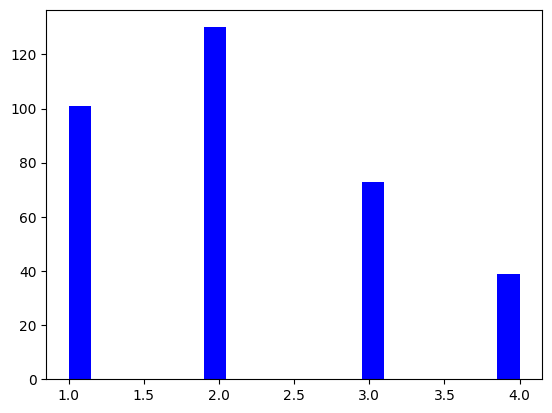

In [9]:
plt.hist(meta_data_aphasia["Aphasia_Severity"].to_list(), bins=20, color="blue", label="Афазия");

In [10]:
sf_aphasia = []
sf_norm = []

noise_aphasia = {}
noise_norm = {}

empty_files = []

In [11]:
for audio_file in tqdm(os.listdir(APHASIA_DIR)):
    y, sr = librosa.load(os.path.join(APHASIA_DIR, audio_file), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    roll_off = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    if spectral_flatness > 0.5:
        empty_files.append(audio_file)
        continue
        
    sf_aphasia.append([audio_file, spectral_flatness, roll_off])
    ind = audio_file.split('-')[1]
    if ind not in noise_aphasia:
        noise_aphasia[str(ind)] = False
    if roll_off < 1_000:
        noise_aphasia[str(ind)] = True

100%|██████████| 608/608 [00:40<00:00, 15.20it/s]


In [12]:
for audio_file in tqdm(os.listdir(NORM_DIR)):
    y, sr = librosa.load(os.path.join(NORM_DIR, audio_file), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    roll_off = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    if spectral_flatness > 0.5:
        empty_files.append(audio_file)
        continue
    
    sf_norm.append([audio_file, spectral_flatness, roll_off])
    ind = audio_file.split('-')[1]
    if ind[0] == '0':
        ind = ind[1:]
    ind += '-НРАТ'
    
    if ind not in noise_norm:
        noise_norm[str(ind)] = False
    if roll_off < 1_000:
        noise_norm[str(ind)] = True

100%|██████████| 202/202 [00:03<00:00, 59.21it/s]


In [13]:
meta_data_aphasia = meta_data_aphasia[meta_data_aphasia["Subj_ID"].isin(noise_aphasia.keys())]
meta_data_norm = meta_data_norm[meta_data_norm["Subj_ID"].isin(noise_norm.keys())]

In [14]:
meta_data_aphasia["has_noise"] = meta_data_aphasia["Subj_ID"].map(noise_aphasia)
meta_data_norm["has_noise"] = meta_data_norm["Subj_ID"].map(noise_norm)

In [15]:
meta_data_aphasia.head()

,Unnamed: 0,Subj_ID,Date_of_birth,Age,Sex (m/f),Education in years,Education level,Stroke_date,Stroked hemisphere,N of strokes,...,Time2.2_file_name,Time3.1_file_name,Time3.2_file_name,Time4.1_file_name,Time4.2_file_name,Time5.1_file_name,Time5.2_file_name,Time6.1_file_name,Time6.2_file_name,has_noise
0,13-РАТ,1,1957-12-04 00:00:00,58.0,f,NaN,высшее,2005-03-27 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,22-РАТ,7,1964-03-21 00:00:00,52.0,m,NaN,высшее,2006-06-20 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,55-РАТ,13,1962-12-06 00:00:00,53.0,m,NaN,сред спец,2008-09-19 00:00:00,L,1.0,...,NaN,A-13-RAT-3-robb,NaN,A-13-RAT-4-bike,NaN,NaN,NaN,NaN,NaN,True
3,Афанасенко СС,35,1963-10-21 00:00:00,53.0,m,NaN,сред спец,2011-09-27 00:00:00,L,1.0,...,NaN,A-35-RAT-3-bike,A-35-RAT-3-robb,NaN,NaN,NaN,NaN,NaN,NaN,True
4,Муксеева ЕА,51,1971-09-22 00:00:00,45.0,f,NaN,высшее,2012-06-16 00:00:00,L,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [16]:
meta_data_aphasia_mild = meta_data_aphasia[meta_data_aphasia["Aphasia_Severity"] == 1]
meta_data_aphasia_moderate = meta_data_aphasia[meta_data_aphasia["Aphasia_Severity"] == 2]
meta_data_aphasia_severe = meta_data_aphasia[meta_data_aphasia["Aphasia_Severity"] == 3]
meta_data_aphasia_dysarthria = meta_data_aphasia[meta_data_aphasia["Aphasia_Severity"] == 4]

In [17]:
train_mild, test_mild = train_test_split(meta_data_aphasia_mild, test_size=0.4, random_state=42,
                                               stratify=meta_data_aphasia_mild["has_noise"])

val_mild, test_mild = train_test_split(test_mild, test_size=0.5, random_state=42,
                                             stratify=test_mild["has_noise"])

train_moderate, test_moderate = train_test_split(meta_data_aphasia_moderate, test_size=0.4, random_state=42,
                                               stratify=meta_data_aphasia_moderate["has_noise"])

val_moderate, test_moderate = train_test_split(test_moderate, test_size=0.5, random_state=42,
                                             stratify=test_moderate["has_noise"])

train_severe, test_severe = train_test_split(meta_data_aphasia_severe, test_size=0.4, random_state=42,
                                               stratify=meta_data_aphasia_severe["has_noise"])

val_severe, test_severe = train_test_split(test_severe, test_size=0.5, random_state=42,
                                             stratify=test_severe["has_noise"])

# Всего один шумный сэмпл
train_dysarthria, test_dysarthria = train_test_split(meta_data_aphasia_dysarthria, test_size=0.4, random_state=42,)

val_dysarthria, test_dysarthria = train_test_split(test_dysarthria, test_size=0.5, random_state=42,)

train_norm, test_norm = train_test_split(meta_data_norm, test_size=0.4, random_state=42, stratify=meta_data_norm["has_noise"])

val_norm, test_norm = train_test_split(test_norm, test_size=0.5, random_state=42, stratify=test_norm["has_noise"])

In [18]:
aphasia_files_list = os.listdir(APHASIA_DIR)
norm_files_list = os.listdir(NORM_DIR)

In [19]:
aphasia_files_dict = {}
norm_files_dict = {}

for audio_file in tqdm(aphasia_files_list):
    participant_id = audio_file.split('-')[1]
    if participant_id not in aphasia_files_dict:
        aphasia_files_dict[participant_id] = [audio_file]
    else:
        aphasia_files_dict[participant_id].append(audio_file)

for audio_file in tqdm(norm_files_list):
    participant_id = audio_file.split('-')[1]
    if participant_id not in norm_files_dict:
        norm_files_dict[participant_id] = [audio_file]
    else:
        norm_files_dict[participant_id].append(audio_file)

100%|██████████| 202/202 [00:00<00:00, 121139.46it/s]


In [20]:
def get_filename(df: pd.DataFrame, label: int):
    output = []
    # file_columns = [x for x in df.columns if "file_name" in x]
    for i, row in df.iterrows():
        participant_id = row['Subj_ID'].split('-')[0]
        # print(participant_id)
        if label:
            file_names = [(x, label) for x in  aphasia_files_dict[participant_id] if x not in empty_files]
        else:
            if len(participant_id) == 3:
                participant_id = '0' + participant_id
            file_names = [(x, label) for x in  norm_files_dict[participant_id] if x not in empty_files]
        output.extend(file_names)
    return output

In [21]:
train_filenames = get_filename(train_norm, 0) + get_filename(train_mild, 1) + get_filename(train_moderate, 2) + get_filename(train_severe, 3) # + get_filename(train_dysarthria, 4)
val_filenames = get_filename(val_norm, 0) + get_filename(val_mild, 1) + get_filename(val_moderate, 2) + get_filename(val_severe, 3) # + get_filename(val_dysarthria, 4)
test_filenames = get_filename(test_norm, 0) + get_filename(test_mild, 1) + get_filename(test_moderate, 2) + get_filename(test_severe, 3) # + get_filename(test_dysarthria, 4)

In [22]:
len(train_filenames), len(val_filenames), len(test_filenames)

(465, 142, 134)

In [23]:
train_filenames = pd.DataFrame(train_filenames, columns=['file_name', 'label'])
val_filenames = pd.DataFrame(val_filenames, columns=['file_name', 'label'])
test_filenames = pd.DataFrame(test_filenames, columns=['file_name', 'label'])

train_filenames.to_csv(os.path.join(DATA_DIR, "train_filenames_mc_1.csv"), index=False)
val_filenames.to_csv(os.path.join(DATA_DIR, "val_filenames_mc_1.csv"), index=False)
test_filenames.to_csv(os.path.join(DATA_DIR, "test_filenames_mc_1.csv"), index=False)

# train_aphasia.to_csv(os.path.join(DATA_DIR, "train_aphasia_mc.csv"), index=False)
# val_aphasia.to_csv(os.path.join(DATA_DIR, "val_aphasia_mc.csv"), index=False)
# test_aphasia.to_csv(os.path.join(DATA_DIR, "test_aphasia_mc.csv"), index=False)
# 
# train_norm.to_csv(os.path.join(DATA_DIR, "train_norm_mc.csv"), index=False)
# val_norm.to_csv(os.path.join(DATA_DIR, "val_norm_mc.csv"), index=False)
# test_norm.to_csv(os.path.join(DATA_DIR, "test_norm_mc.csv"), index=False)